### Imports

In [1]:
import torch
from torchvision import (
    datasets,
    transforms
)
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

## Inputs

In [2]:
# Set device to gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Continue training from saved model point?
continue_train = False

# file paths
dataset_path = './datasets/'
netD_pt = './models/EMNIST-GAN-netD.pt'
netG_pt = './models/EMNIST-GAN-netG.pt'

# model parameters
n_epochs = 20
batch_size = 256
learning_rate = 0.0005
momentum = 0.9
beta1 = 0.5 # param for Adam optimizers

nz = 100 # input length
ngf = 64 # generator feature map depth
n_out_g = 1 # generator output
ndf = 28 # discriminator feature map depth
nc = 47 # output channels

# log writer for tensorboard
writer = SummaryWriter('./logs/EMNIST-GAN')

# seed used by PyTorch for repeatable testing
random_seed = 1
torch.manual_seed(random_seed)

# EMNIST classes
classes = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

## Data

In [3]:
# transformers for datasets
# training set will get additional data augmentation for better training diversity
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.1307,),(0.3081,))])

test_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(
        (0.1307,),(0.3081,))])

# load datasets
train_dataset = datasets.EMNIST(
    dataset_path,
    split = 'balanced',
    train = True,
    download = True,
    transform = train_transform)

test_dataset = datasets.EMNIST(
    dataset_path,
    split = 'balanced',
    train = False,
    download = True,
    transform = test_transform)

# wrap datasets in DataLoaders
def get_data(train_dataset, test_dataset, batch_size):
    return (
        torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
        torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    )

In [4]:
mnist_dataset = datasets.MNIST(
    dataset_path,
    download = True,
    transform = train_transform
)

mnist_dl = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

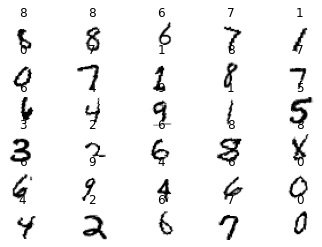

In [5]:
train_ld, test_ld = get_data(train_dataset, test_dataset, batch_size)

dataiter = iter(mnist_dl)
images, labels = dataiter.next()

# view sample of images and corresponding labels from batch
figure = plt.figure()
num_of_images = 30
for i in range(1, 31):
    plt.subplot(6, 5, i)
    plt.axis('off')
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    plt.title(classes[labels[i].item()])

In [6]:
print(images.shape)

torch.Size([256, 1, 28, 28])


## Implementation

### Generator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(nz, 64 * 11 * 11),
            nn.BatchNorm1d(64 * 11 * 11),
            nn.LeakyReLU(),
            nn.Unflatten(1, (64, 11, 11)))
        
        self.conv = nn.Sequential(            
            nn.ConvTranspose2d(64, 128, kernel_size=5, stride=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, n_out_g, kernel_size=4, stride=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.linear(x)
        x = self.conv(x)
        return x
    
summary(Generator(), (batch_size, nz), col_names=['input_size', 'output_size', 'kernel_size', 'num_params'], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Kernel Shape         Param #
Generator                                --                   --                   --                   --
├─Sequential: 1-1                        [256, 100]           [256, 64, 11, 11]    --                   --
│    └─Linear: 2-1                       [256, 100]           [256, 7744]          [100, 7744]          782,144
│    └─BatchNorm1d: 2-2                  [256, 7744]          [256, 7744]          [7744]               15,488
│    └─LeakyReLU: 2-3                    [256, 7744]          [256, 7744]          --                   --
│    └─Unflatten: 2-4                    [256, 7744]          [256, 64, 11, 11]    --                   --
├─Sequential: 1-2                        [256, 64, 11, 11]    [256, 1, 28, 28]     --                   --
│    └─ConvTranspose2d: 2-5              [256, 64, 11, 11]    [256, 128, 25, 25]   [128, 64, 5, 5]      204,800
│    └─BatchNorm2d

### Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(            
            nn.Conv2d(n_out_g, 64, 5, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 5, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(2048, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x.reshape(x.shape[0])
        return x
    
summary(Discriminator(), (batch_size, 1, 28, 28), col_names=['input_size', 'output_size', 'kernel_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
Discriminator                            --                        --                        --                        --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 1]                  --                        --
│    └─Conv2d: 2-1                       [256, 1, 28, 28]          [256, 64, 12, 12]         [1, 64, 5, 5]             1,664
│    └─BatchNorm2d: 2-2                  [256, 64, 12, 12]         [256, 64, 12, 12]         [64]                      128
│    └─LeakyReLU: 2-3                    [256, 64, 12, 12]         [256, 64, 12, 12]         --                        --
│    └─Conv2d: 2-4                       [256, 64, 12, 12]         [256, 128, 4, 4]          [64, 128, 5, 5]           204,928
│    └─BatchNorm2d: 2-5                  [256, 128, 4, 4]          [256, 128, 4, 4]          [128]                     256
│    └─Le

### Weight Initialization

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
netG = Generator().to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2048, out_features=128, bias=True)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Linear(in_features=128, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

### Loss functions and Optimizers

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### Training

In [12]:
if False:
    netD = torch.load(netD_pt)
    netG = torch.load(netG_pt)

    print("netD's state_dict:")
    for param_tensor in netD.state_dict():
        print(param_tensor, "\t", netD.state_dict()[param_tensor].size())
    print()
    print("netG's state_dict:")
    for param_tensor in netG.state_dict():
        print(param_tensor, "\t", netG.state_dict()[param_tensor].size())

In [13]:
img_list = []
G_losses = []
D_losses = []
dataloader = mnist_dl
#dataloader = train_ld

def train(n_epochs):
    for epoch in range(n_epochs):        
        for i, (imgs, _) in enumerate(dataloader):

            '''
            Train real batches
            '''
            netD.zero_grad()
            # Format Data
            real_img = imgs.to(device)
            batch_size = real_img.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            # Pass batch to Discriminator
            output = netD(real_img)
            # Compute loss from Discriminator
            #print(output.shape, label.shape)
            errD_real = criterion(output, label)
            # Compute gradients 
            errD_real.backward()
            # Average output of Discriminator across batch
            D_x = output.mean().item()
            
            '''
            Train fake batches
            '''
            # Generate batch of random noise
            noise = torch.randn(batch_size, nz, device=device)
            # Generate batch of fake images
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify fake images with Discriminator
            output = netD(fake.detach()).view(-1)
            # Compute loss from Discriminator
            errD_fake = criterion(output, label)
            # Compute gradients, summed with previous gradients
            errD_fake.backward()
            # Average output of Discriminator across Fake image batch
            D_G_z1 = output.mean().item()
            # Summ loss of Discriminator over real and fake images
            errD = errD_real + errD_fake
            # Update Discriminator
            optimizerD.step()
            
            '''
            Update Generator Network
            '''
            netG.zero_grad()
            # Set labels to 'real' for generator cost
            label.fill_(real_label)
            # Pass the fake batch again since updating Discriminator
            output = netD(fake).view(-1)
            # Compute Generator loss
            errG = criterion(output, label)
            # Compute Generator gradients
            errG.backward()
            # Average output of Discriminator across Fake image batch
            D_G_z2 = output.mean().item()
            # Update Generator
            optimizerG.step()
            
            # Save losses for metrics
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            if (i % 101 == 100) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
                # Save fake images for viewing
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, normalize=True))
                
                # Print training info
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                        % (epoch, n_epochs, i, len(dataloader),
                            errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        if epoch % 5 == 0: 
            # Display batch of images each epoch
            plt.figure(figsize=(16,16))
            plt.axis("off")
            plt.title("Fake Images")
            plt.imshow(np.transpose(img_list[-1],(1,2,0)))
            plt.show()
                    
        torch.save(netD, netD_pt)
        torch.save(netG, netG_pt)

[0/20][100/235]	Loss_D: 1.1846	Loss_G: 0.8829	D(x): 0.5496	D(G(z)): 0.4321 / 0.4213
[0/20][201/235]	Loss_D: 1.2166	Loss_G: 0.8353	D(x): 0.5518	D(G(z)): 0.4493 / 0.4403


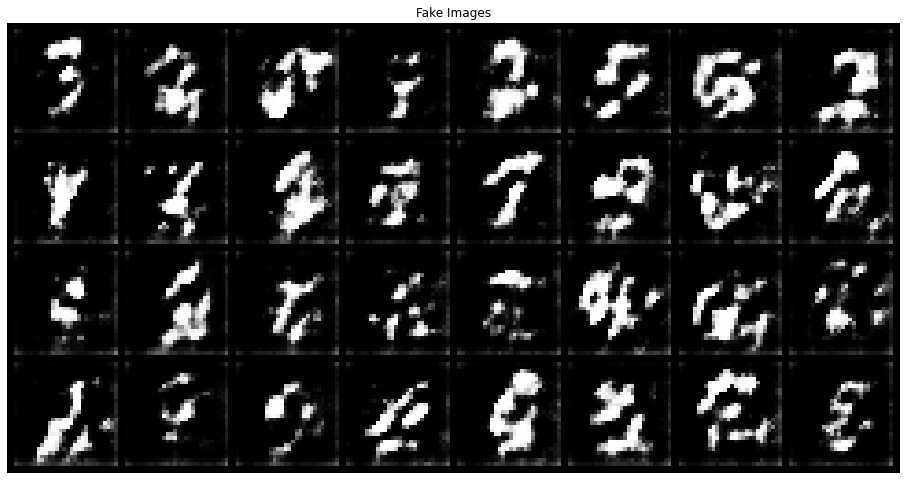

[1/20][100/235]	Loss_D: 1.0890	Loss_G: 0.9435	D(x): 0.5891	D(G(z)): 0.4082 / 0.4010
[1/20][201/235]	Loss_D: 1.1947	Loss_G: 0.9253	D(x): 0.5540	D(G(z)): 0.4279 / 0.4100
[2/20][100/235]	Loss_D: 1.1862	Loss_G: 0.9090	D(x): 0.5708	D(G(z)): 0.4423 / 0.4152
[2/20][201/235]	Loss_D: 1.1999	Loss_G: 1.0128	D(x): 0.5645	D(G(z)): 0.4228 / 0.4101
[3/20][100/235]	Loss_D: 1.0605	Loss_G: 1.0377	D(x): 0.5885	D(G(z)): 0.3863 / 0.3716
[3/20][201/235]	Loss_D: 1.1377	Loss_G: 1.1378	D(x): 0.5978	D(G(z)): 0.3981 / 0.3599
[4/20][100/235]	Loss_D: 0.9748	Loss_G: 1.1705	D(x): 0.6602	D(G(z)): 0.3873 / 0.3514
[4/20][201/235]	Loss_D: 0.9683	Loss_G: 1.1857	D(x): 0.6220	D(G(z)): 0.3551 / 0.3313
[5/20][100/235]	Loss_D: 0.9338	Loss_G: 1.3091	D(x): 0.6434	D(G(z)): 0.3515 / 0.2963
[5/20][201/235]	Loss_D: 0.8888	Loss_G: 1.1873	D(x): 0.6360	D(G(z)): 0.3121 / 0.3349


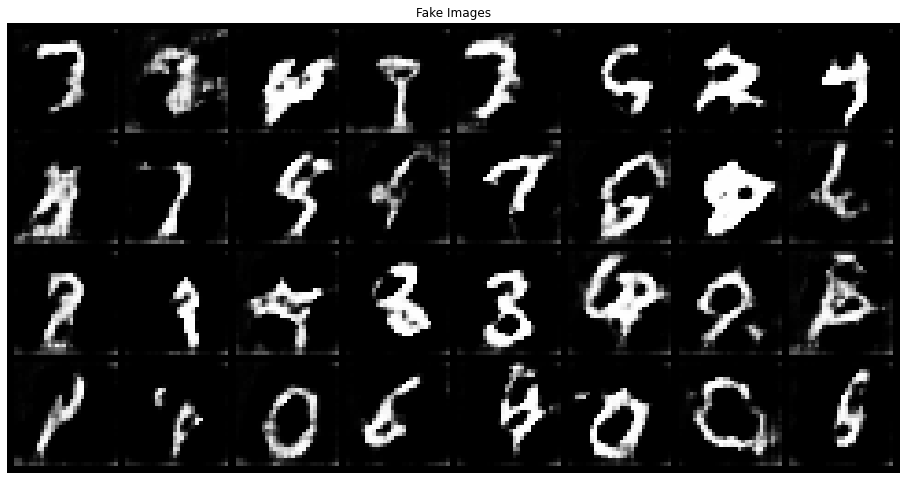

[6/20][100/235]	Loss_D: 0.8792	Loss_G: 1.4750	D(x): 0.6809	D(G(z)): 0.3305 / 0.2819
[6/20][201/235]	Loss_D: 0.9251	Loss_G: 1.3013	D(x): 0.6577	D(G(z)): 0.3413 / 0.2981
[7/20][100/235]	Loss_D: 0.9540	Loss_G: 1.3391	D(x): 0.6087	D(G(z)): 0.2900 / 0.3025
[7/20][201/235]	Loss_D: 0.8106	Loss_G: 1.4339	D(x): 0.6669	D(G(z)): 0.2814 / 0.2837
[8/20][100/235]	Loss_D: 0.7012	Loss_G: 1.4917	D(x): 0.7426	D(G(z)): 0.2862 / 0.2581
[8/20][201/235]	Loss_D: 0.7801	Loss_G: 1.4159	D(x): 0.7246	D(G(z)): 0.3135 / 0.2901
[9/20][100/235]	Loss_D: 0.7054	Loss_G: 1.4574	D(x): 0.7073	D(G(z)): 0.2517 / 0.2737
[9/20][201/235]	Loss_D: 0.6110	Loss_G: 1.8625	D(x): 0.7874	D(G(z)): 0.2654 / 0.1874
[10/20][100/235]	Loss_D: 0.7011	Loss_G: 1.5219	D(x): 0.7329	D(G(z)): 0.2672 / 0.2502
[10/20][201/235]	Loss_D: 0.7338	Loss_G: 1.7748	D(x): 0.7310	D(G(z)): 0.2830 / 0.2184


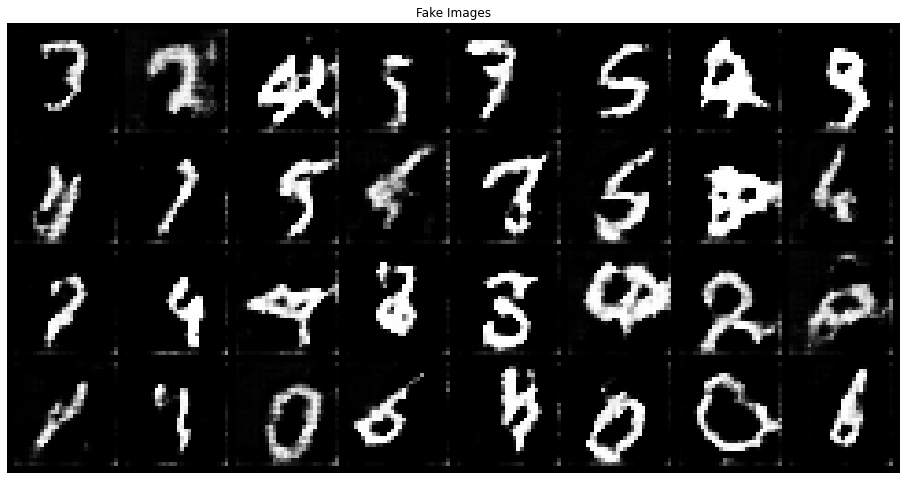

[11/20][100/235]	Loss_D: 0.7047	Loss_G: 1.5667	D(x): 0.7183	D(G(z)): 0.2650 / 0.2502
[11/20][201/235]	Loss_D: 0.6627	Loss_G: 1.8372	D(x): 0.7264	D(G(z)): 0.2350 / 0.1972
[12/20][100/235]	Loss_D: 0.6213	Loss_G: 1.7968	D(x): 0.7411	D(G(z)): 0.2110 / 0.2232
[12/20][201/235]	Loss_D: 0.6154	Loss_G: 1.9208	D(x): 0.7809	D(G(z)): 0.2525 / 0.1894
[13/20][100/235]	Loss_D: 0.5835	Loss_G: 2.2025	D(x): 0.8193	D(G(z)): 0.2583 / 0.1488
[13/20][201/235]	Loss_D: 0.7257	Loss_G: 2.2059	D(x): 0.7437	D(G(z)): 0.2791 / 0.1613
[14/20][100/235]	Loss_D: 0.5779	Loss_G: 2.2678	D(x): 0.8234	D(G(z)): 0.2673 / 0.1484
[14/20][201/235]	Loss_D: 0.5502	Loss_G: 2.1029	D(x): 0.7957	D(G(z)): 0.2063 / 0.1673
[15/20][100/235]	Loss_D: 0.6402	Loss_G: 1.8962	D(x): 0.7696	D(G(z)): 0.2389 / 0.1963
[15/20][201/235]	Loss_D: 0.5176	Loss_G: 2.0682	D(x): 0.8019	D(G(z)): 0.2065 / 0.1744


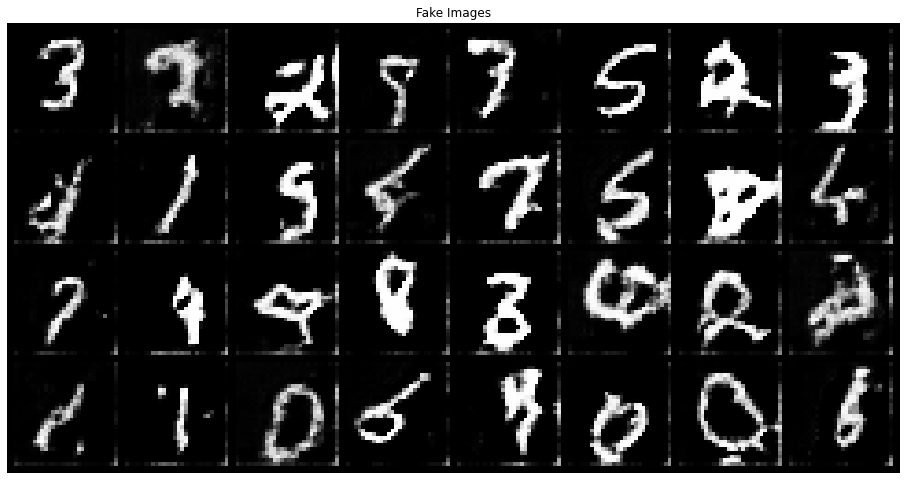

[16/20][100/235]	Loss_D: 0.8165	Loss_G: 1.9696	D(x): 0.7151	D(G(z)): 0.2420 / 0.2906
[16/20][201/235]	Loss_D: 0.5513	Loss_G: 2.4529	D(x): 0.8233	D(G(z)): 0.2332 / 0.1290
[17/20][100/235]	Loss_D: 0.4864	Loss_G: 2.0125	D(x): 0.8171	D(G(z)): 0.2034 / 0.1721
[17/20][201/235]	Loss_D: 0.4895	Loss_G: 2.5071	D(x): 0.8174	D(G(z)): 0.1899 / 0.1497
[18/20][100/235]	Loss_D: 0.5685	Loss_G: 2.3493	D(x): 0.7875	D(G(z)): 0.2127 / 0.1453
[18/20][201/235]	Loss_D: 0.5713	Loss_G: 1.9269	D(x): 0.7218	D(G(z)): 0.1527 / 0.2130
[19/20][100/235]	Loss_D: 0.5521	Loss_G: 2.2596	D(x): 0.8093	D(G(z)): 0.2157 / 0.1662
[19/20][201/235]	Loss_D: 0.4315	Loss_G: 2.1959	D(x): 0.8780	D(G(z)): 0.2110 / 0.1547
[19/20][234/235]	Loss_D: 0.9558	Loss_G: 3.1193	D(x): 0.7475	D(G(z)): 0.3123 / 0.2864


In [14]:
train(n_epochs)

## Results

### Loss

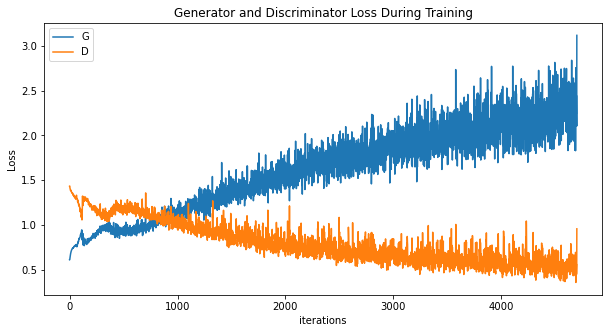

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

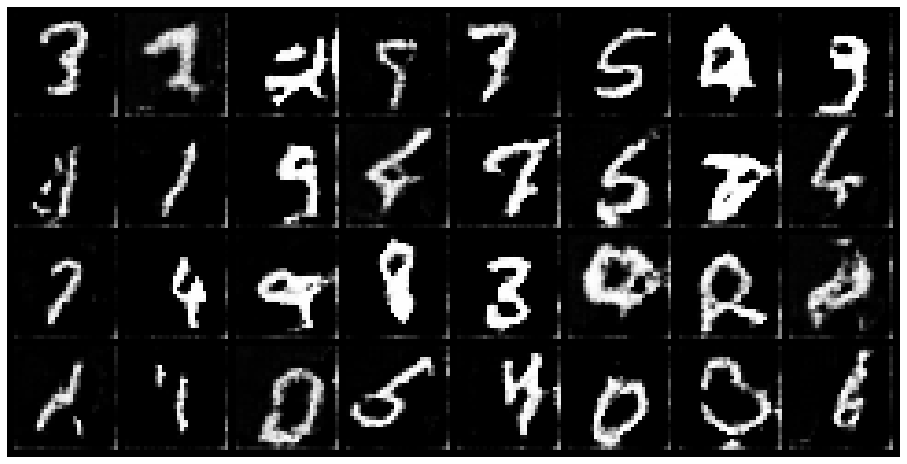

In [16]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(16,16))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

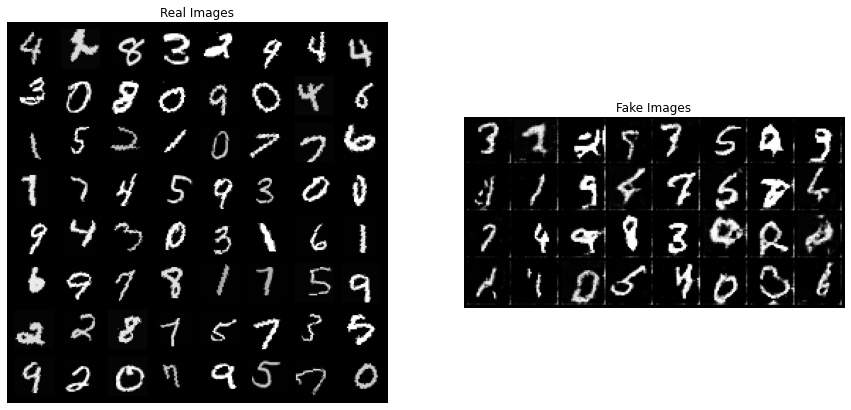

In [19]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [18]:
print("netD's state_dict:")
for param_tensor in netD.state_dict():
    print(param_tensor, "\t", netD.state_dict()[param_tensor].size())
print()
print("netG's state_dict:")
for param_tensor in netG.state_dict():
    print(param_tensor, "\t", netG.state_dict()[param_tensor].size())

netD's state_dict:
main.0.weight 	 torch.Size([64, 1, 5, 5])
main.0.bias 	 torch.Size([64])
main.1.weight 	 torch.Size([64])
main.1.bias 	 torch.Size([64])
main.1.running_mean 	 torch.Size([64])
main.1.running_var 	 torch.Size([64])
main.1.num_batches_tracked 	 torch.Size([])
main.3.weight 	 torch.Size([128, 64, 5, 5])
main.3.bias 	 torch.Size([128])
main.4.weight 	 torch.Size([128])
main.4.bias 	 torch.Size([128])
main.4.running_mean 	 torch.Size([128])
main.4.running_var 	 torch.Size([128])
main.4.num_batches_tracked 	 torch.Size([])
main.7.weight 	 torch.Size([128, 2048])
main.7.bias 	 torch.Size([128])
main.8.weight 	 torch.Size([128])
main.8.bias 	 torch.Size([128])
main.8.running_mean 	 torch.Size([128])
main.8.running_var 	 torch.Size([128])
main.8.num_batches_tracked 	 torch.Size([])
main.10.weight 	 torch.Size([1, 128])
main.10.bias 	 torch.Size([1])

netG's state_dict:
linear.0.weight 	 torch.Size([7744, 100])
linear.0.bias 	 torch.Size([7744])
linear.1.weight 	 torch.Size([7